In [ ]:

%%capture

# Install the required libraries.
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1572864/45929032 bytes (3.4%)3342336/45929032 bytes (7.3%)5709824/45929032 bytes (12.4%)8454144/45929032 bytes (18.4%)11354112/45929032 bytes (24.7%)13762560/45929032 bytes (30.0%)16113664/45929032 bytes (35.1%)18407424/45929032 bytes (40.1%)21372928/45929032 bytes (46.5%)23560192/45929032 bytes (51.3%)26370048/45929032 bytes (57.4%)28917760/45929032 bytes (63.0%)316

In [ ]:
%%capture

!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar

The Dataset contains:

50 Action Categories

25 Groups of Videos per Action Category

133 Average Videos per Action Category

199 Average Number of Frames per Video

26 Average Frames Per Seconds per Video

In [ ]:
def plot_metric(model_training_history, metric_name1, metric_name2, plot_name):

    metric1 = model_training_history.history[metric_name1]
    metric2 = model_training_history.history[metric_name2]
    
    epochs = range(len(metric1))

    plt.plot(epochs, metric1, 'blue', label = metric_name1)
    plt.plot(epochs, metric2, 'red', label = metric_name2)

    plt.title(str(plot_name))

    plt.legend()

In [ ]:
img_height , img_width = 64, 64

seq_len= 20
DATASET_DIR = "UCF50"


label_lst = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

In [ ]:
seed_constant = 27                         #control randomness of the project(image display & model)
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
def frames_extraction(video_path):                 


    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frame = max(int(video_frames_count/seq_len), 1)


    for frame_counter in range(seq_len):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frame)

        success, frame = video_reader.read() 


        if not success:
            break

        resized_frame = cv2.resize(frame, (img_height, img_width))
  
        normalized_frame = resized_frame / 255          #smoothening out (better training, better image)
        

        frames_list.append(normalized_frame)

    video_reader.release()


    return frames_list

In [ ]:
def create_dataset():              #extracting data for the exercises(label)


    features = []
    labels = []
    video_path = []
    
    for class_index, class_name in enumerate(label_lst):
        

        print(f'Extracting Data of Class: {class_name}')
        

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        

        for file_name in files_list:
            

            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == seq_len:

        
                features.append(frames)
                labels.append(class_index)
                video_path.append(video_file_path)


    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_path

In [ ]:
features, labels, video_path = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


In [ ]:
encoded_labels = to_categorical(labels)       #one-hot encoded labels

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
def create_convlstm_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (seq_len,
                                                                                      img_height, img_width, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))    #reduce size
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))                                               #feature maps
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

    model.add(Flatten()) 
    
    model.add(Dense(len(label_lst), activation = "softmax"))   #the hidden layers
  
    model.summary()
    

    return model

In [ ]:

convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 30, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])


Epoch 1/30
73/73 [==============================] - 160s 2s/step - loss: 1.3925 - accuracy: 0.2774 - val_loss: 1.3683 - val_accuracy: 0.3562
Epoch 2/30
73/73 [==============================] - 150s 2s/step - loss: 1.3634 - accuracy: 0.3288 - val_loss: 1.3426 - val_accuracy: 0.5068
Epoch 3/30
73/73 [==============================] - 152s 2s/step - loss: 1.2549 - accuracy: 0.4829 - val_loss: 1.1315 - val_accuracy: 0.4658
Epoch 4/30
73/73 [==============================] - 148s 2s/step - loss: 1.0977 - accuracy: 0.5411 - val_loss: 1.1070 - val_accuracy: 0.5479
Epoch 5/30
73/73 [==============================] - 149s 2s/step - loss: 0.8399 - accuracy: 0.6233 - val_loss: 0.8137 - val_accuracy: 0.6438
Epoch 6/30
73/73 [==============================] - 155s 2s/step - loss: 0.7128 - accuracy: 0.6849 - val_loss: 0.6471 - val_accuracy: 0.7260
Epoch 7/30
73/73 [==============================] - 153s 2s/step - loss: 0.5094 - accuracy: 0.8116 - val_loss: 0.7248 - val_accuracy: 0.6986
Epoch 8/30
73

In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

4/4 [==============================] - 14s 3s/step - loss: 0.3037 - accuracy: 0.8852


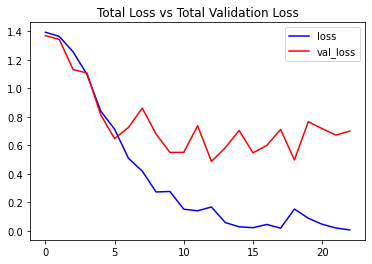

In [ ]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

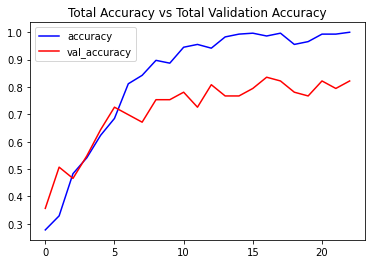

In [ ]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

LRCN model 

In [ ]:
def create_LRCN_model():
    model = Sequential()

    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (seq_len, img_height, img_width, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(label_lst), activation = 'softmax'))

    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 20, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 4, 4, 32)    

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
73/73 [==============================] - 16s 189ms/step - loss: 1.3746 - accuracy: 0.3253 - val_loss: 1.3176 - val_accuracy: 0.3562
Epoch 2/70
73/73 [==============================] - 13s 179ms/step - loss: 1.3073 - accuracy: 0.3938 - val_loss: 1.2854 - val_accuracy: 0.4110
Epoch 3/70
73/73 [==============================] - 13s 180ms/step - loss: 1.1701 - accuracy: 0.5068 - val_loss: 1.2416 - val_accuracy: 0.3973
Epoch 4/70
73/73 [==============================] - 13s 180ms/step - loss: 1.0803 - accuracy: 0.5616 - val_loss: 1.2180 - val_accuracy: 0.4932
Epoch 5/70
73/73 [==============================] - 14s 188ms/step - loss: 0.9243 - accuracy: 0.6062 - val_loss: 0.7506 - val_accuracy: 0.7123
Epoch 6/70
73/73 [==============================] - 13s 182ms/step - loss: 0.8728 - accuracy: 0.6404 - val_loss: 0.7535 - val_accuracy: 0.7123
Epoch 7/70
73/73 [==============================] - 13s 184ms/step - loss: 0.7298 - accuracy: 0.6918 - val_loss: 0.7102 - val_accuracy: 0.7260

In [ ]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 [==============================] - 2s 392ms/step - loss: 0.3689 - accuracy: 0.9180


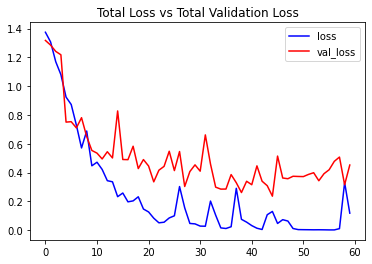

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

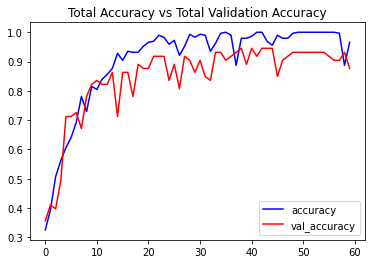

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):


     video = pafy.new(youtube_video_url)
 

     title = video.title
 
     # Get the best available quality object for the video.
     video_best = video.getbest()
 

     output_file_path = f'{output_directory}/{title}.mp4'
 
     video_best.download(filepath = output_file_path, quiet = True)

     return title

In [ ]:

test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_videos_directory)

video_path = f'{test_videos_directory}/{video_title}.mp4'

In [ ]:
def predict_on_video(file_path, output_file_path, seq_len):

    video_reader = cv2.VideoCapture(file_path)

    video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (video_width, video_height))

    frames_queue = deque(maxlen = seq_len)


    predicted_class_name = ''


    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (img_height, img_width))
        

        normalized_frame = resized_frame / 255

        frames_queue.append(normalized_frame)


        if len(frames_queue) == seq_len:


            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]


            predicted_label = np.argmax(predicted_labels_probabilities)

            predicted_class_name = label_lst[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)
        
 
    video_reader.release()
    video_writer.release()

In [ ]:

output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{seq_len}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(video_path, output_video_file_path, seq_len)

VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

100%|██████████| 867/867 [00:03<00:00, 288.00it/s]
